# Project 3: Web APIs and NLP <br>

#### Brandie Hatch

### Modeling

## Imports, Data Reading, and Model Prep

In [112]:
# python library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.svm import LinearSVC, SVC 
from sklearn.feature_extraction.text import CountVectorizer


%matplotlib inline
pd.options.display.max_columns =999

import requests
import time
import re
import nltk

In [113]:
# Read in Data

df = pd.read_csv('../data/prepped.csv', index_col=False)
print(df.shape)
df.head()

(9150, 11)


,subreddit,title,selftext,ups,score,num_comments,subreddit_num,title_length,title_word_count,selftext_length,selftext_word_count
0,Dogtraining,Trick of the Month - May 2022 - Crawl Backwards,Welcome to the Trick of the Month!\n\nThis mon...,8,8,4,1,47,10,856,140
1,Dogtraining,How do I get a cafe/brewery dog?,I am sitting at a brewery right now and all th...,311,311,88,1,32,7,337,67
2,Dogtraining,Warning: Gross,I noticed my dog trying to eat the poop of oth...,19,19,40,1,14,2,249,49
3,Dogtraining,My 3 months samoyed forgot all his training af...,"As the title says, after having stomach issues...",28,28,18,1,71,14,680,138
4,Dogtraining,Two mat questions!,Hi! I have a dog bed in the living room and I’...,6,6,0,1,18,3,797,157


In [156]:
df['text'] = df['title'] + " " + df['selftext']

In [157]:
# imported data split between two subreddits
df['subreddit'].value_counts(normalize=True)

Dogtraining    0.502732
DogCare        0.497268
Name: subreddit, dtype: float64

In [158]:
# Create X and y using StandardScaler to scale values

X = df[['ups', 'score', 'num_comments', 'title_length', 'title_word_count', 'text']]
y = df['subreddit_num']

In [159]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [160]:
# calculate the baseline accuracy (% of the majority class, dogtraining)
# benchmark to beat is .502732
y.value_counts(normalize=True)

1    0.502732
0    0.497268
Name: subreddit_num, dtype: float64

## Modeling

### Random Forest Classifier

In [161]:
# column transformer, countvectorizer needs to only go to the text columns
col_trans = ColumnTransformer([
    ('cvex', CountVectorizer(lowercase=True, stop_words={'english'}), 'text'),
    ('ss', StandardScaler(), ['ups', 'score', 'num_comments', 'title_length', 'title_word_count'])],
    remainder='passthrough',
    sparse_threshold=0
)

In [162]:
col_trans.fit_transform(X_train)

array([[ 0.        ,  0.        ,  1.        , ..., -0.48355091,
        -0.85376394, -0.78442738],
       [ 0.        ,  0.        ,  0.        , ...,  2.34780794,
        -1.10887596, -1.09369809],
       [ 0.        ,  0.        ,  1.        , ..., -0.19315513,
         0.86824219,  1.0711969 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.19315513,
        -1.04509795, -0.78442738],
       [ 0.        ,  0.        ,  0.        , ...,  0.67803221,
         0.07101713, -0.32052131],
       [ 0.        ,  0.        ,  0.        , ...,  0.16983959,
         2.62213733,  3.08145653]])

In [163]:
# pipeline StandardScaler + instantiate RandomForestClassifier
pipe = Pipeline([
    ('col_trans', col_trans),
    ('rf', RandomForestClassifier())
])

In [138]:
params = {
    'rf__n_estimators': [1, 100, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5]
}
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

1.0


{'rf__max_depth': None, 'rf__n_estimators': 1}

In [139]:
print(y_train.mean(), y_test.mean())

0.5027322404371585 0.5027322404371585


In [140]:
pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.826523,0.120855,0.187891,0.014395,None,1,"{'rf__max_depth': None, 'rf__n_estimators': 1}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
8,1.914670,0.017563,0.208299,0.004420,2,200,"{'rf__max_depth': 2, 'rf__n_estimators': 200}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
16,1.699401,0.010544,0.197397,0.006706,5,100,"{'rf__max_depth': 5, 'rf__n_estimators': 100}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
14,2.487259,0.016354,0.213405,0.002886,4,200,"{'rf__max_depth': 4, 'rf__n_estimators': 200}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
13,1.600158,0.013762,0.201453,0.008359,4,100,"{'rf__max_depth': 4, 'rf__n_estimators': 100}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
11,2.228235,0.014605,0.219363,0.007278,3,200,"{'rf__max_depth': 3, 'rf__n_estimators': 200}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
10,1.481486,0.008530,0.194364,0.003411,3,100,"{'rf__max_depth': 3, 'rf__n_estimators': 100}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
1,1.865597,0.024506,0.200858,0.003914,None,100,"{'rf__max_depth': None, 'rf__n_estimators': 100}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
17,2.676149,0.008952,0.216083,0.002489,5,200,"{'rf__max_depth': 5, 'rf__n_estimators': 200}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
2,3.055199,0.045835,0.246449,0.050258,None,200,"{'rf__max_depth': None, 'rf__n_estimators': 200}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1


In [141]:
gs.score(X_train, y_train)

1.0

In [142]:
gs.score(X_test, y_test)

1.0

### Decision Tree Classifier

I was curious about the differences.

In [128]:
null_model = DummyRegressor()
null_model.fit(X_train, y_train)

mean_squared_error(y_train, null_model.predict(X_train))

0.2499925348621935

In [129]:
tree = DecisionTreeClassifier(random_state=1, max_depth=3)

In [111]:
tree.fit(X_train, y_train)

tree.score(X_train, y_train), tree.score(X_test, y_test)

ValueError: could not convert string to float: 'Adjusting to New Puppy Since getting a puppy a few weeks ago, our 3 year old dog decided he no longer needs to listen to recall. I’m at my wits end as he just ran off into the woods for 10 minutes this morning. We have been using high reward treats in the yard the past couple of days, as I would call for him to come from the back acre and he would completely ignore me. He doesn’t listen to my boyfriend when he calls for him either. Even around the house, our 3 year old dog doesn’t listen. He chases the cat and we redirect him to something else or just to come for a treat if he leaves the cat be. Yet he doesn’t care. We’re gonna get some high reward treats at the pet store today. I’m trying to spend so much one on one time with him and do some relationship building yet it’s not working. We walk 2 miles every morning without the puppy and we have agility classes once a week. I’m really sad to see my dog act this way. I know he’s just feeling out of place with the puppy around, so I’m trying to make sure we focus on our individual relationship to. Open for feedback on how to get him to listen again.'

In [121]:
pd.Series(tree.predict(X_test)).value_counts()

0    1795
1     950
dtype: int64

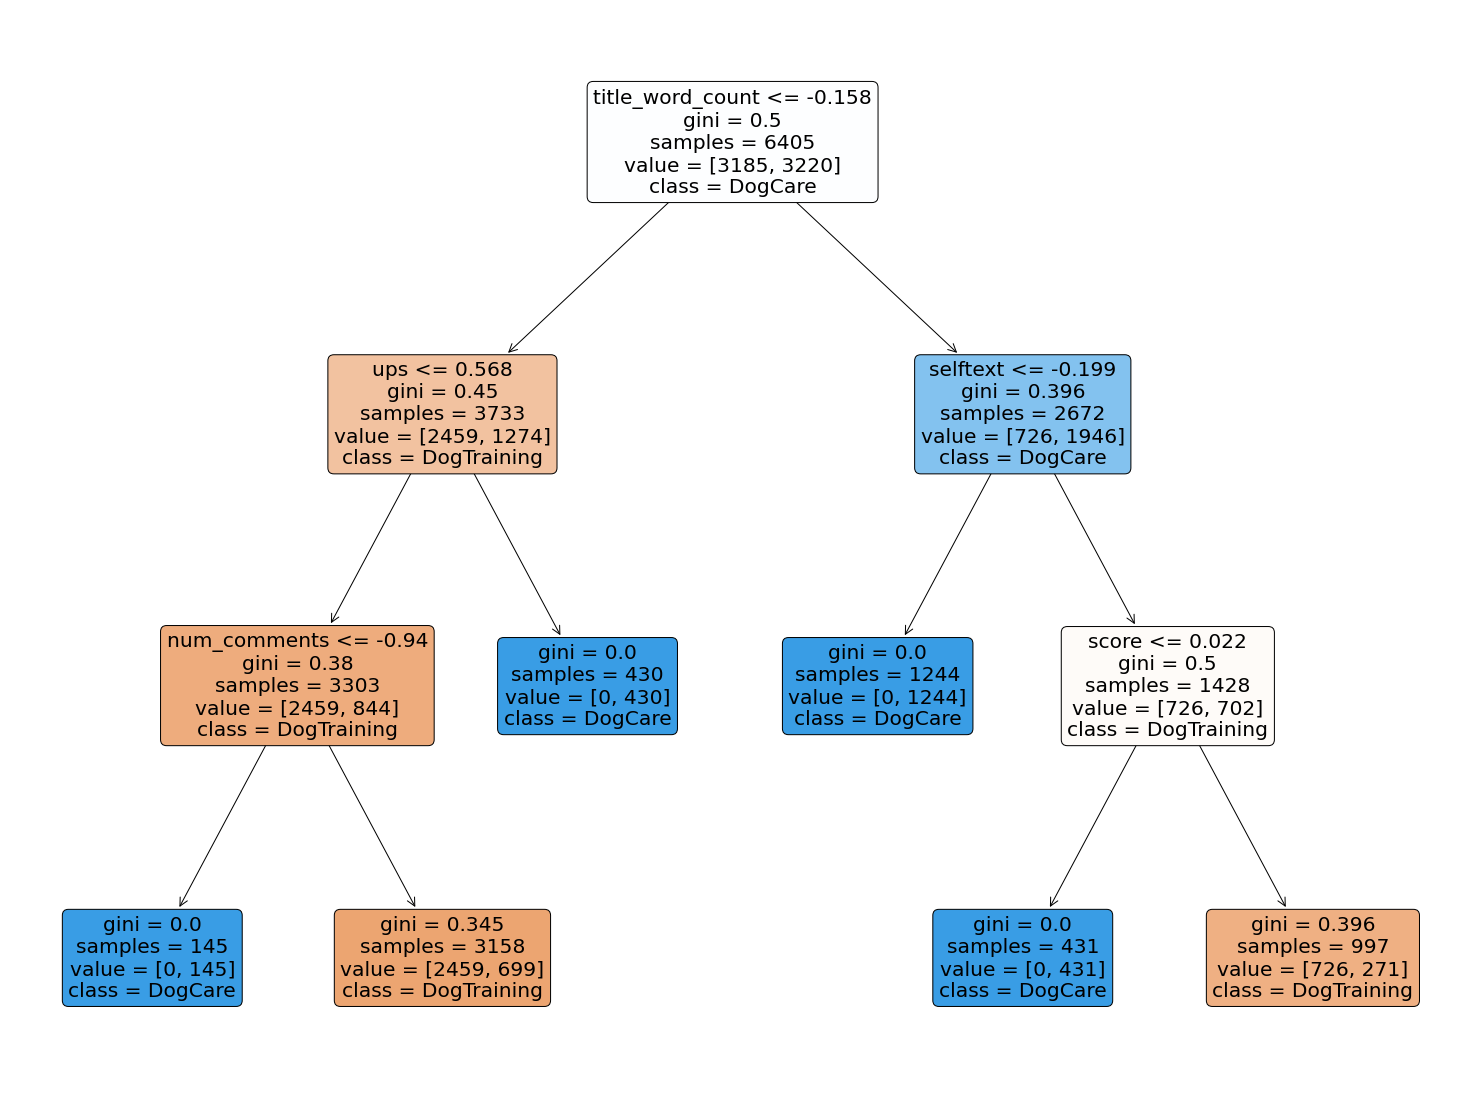

In [123]:
plt.figure(figsize=(26, 20))

plot_tree(
    tree, 
    filled=True, 
    feature_names=X.columns, 
    class_names=['DogTraining', 'DogCare'], 
    rounded=True
);

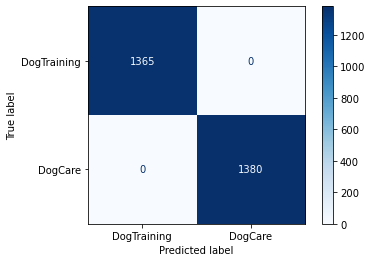

In [143]:
ConfusionMatrixDisplay.from_estimator(
    gs, 
    X_test, 
    y_test, 
    display_labels=['DogTraining', 'DogCare'], 
    cmap='Blues'
);

In [144]:
accuracy_score(y_test, gs.predict(X_test))

1.0

In [145]:
y_test.sum()/y_test.count()

0.5027322404371585

In [146]:
roc_auc_score(y_test, gs.predict(X_test))

1.0

In [147]:
precision_score(y_test, gs.predict(X_test))

1.0

In [149]:
recall_score(y_test, gs.predict(X_test))

1.0

In [150]:
# specificity
recall_score(y_test, gs.predict(X_test), pos_label=0)

1.0

In [151]:
f1_score(y_test, gs.predict(X_test))

1.0

In [152]:
y_test.value_counts(normalize=True)

1    0.502732
0    0.497268
Name: subreddit_num, dtype: float64

### Support Vector Machines (SVM): Linear SVC & C-Support Vector Classification

In [153]:
# define linspace variable
pgrid = {
    'C': np.linspace(0.0001, 1, 20)
}

In [155]:
# instantiate and fit gridsearch
gs_svm = GridSearchCV(LinearSVC(max_iter=5000), pgrid)

gs_svm.fit(X, y)

c:\Users\hatch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hatch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hatch\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 246, in fit
    X, y = self._validate_data(
  File "c:\Users\hatch\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\hatch\anaconda3\lib\site

ValueError: could not convert string to float: "Trick of the Month - May 2022 - Crawl Backwards Welcome to the Trick of the Month!\n\nThis month we'll be teaching our dogs to crawl backwards! You can use free shaping to teach this or combine 'down' and 'move backwards' if your dog already knows those two tricks. Free shaping is a great trick training technique and fun activity to do with your dog!\n\n**How it works:**\n\n1. Teach a dog the trick.\n2. Film the dog performing the trick.\n3. Upload a video/picture to the internet.\n4. Post a link to video or pictures of your results here in the comments.\n\n**Training Resources to get you started:**\n\n[Video tutorial using free shaping](https://youtu.be/LLtptXjYx-Y)\n\nDoes your dog already know this trick? Post a video or photo and brag about it! Post any questions and results on this thread. Good luck and happy training!\n\nHave an idea for a trick you'd like to see featured? Let me know, leave a comment!"

In [145]:
print(gs_svm.best_score_)
print(gs_svm.best_params_)

0.7707103825136612
{'C': 0.21060526315789474}


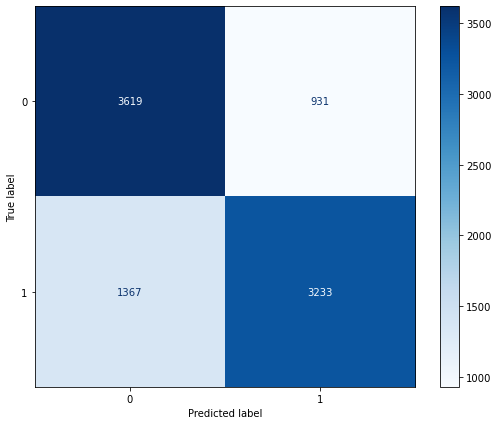

In [146]:
fig, ax = plt.subplots(figsize=(9, 7))
ConfusionMatrixDisplay.from_estimator(gs_svm, X_ss, y, cmap='Blues', ax=ax);

In [147]:
(3619+1)/(3619+1+1367+3)

0.7254509018036072

In [165]:
y_test

6233    0
609     1
9019    0
3354    1
4256    1
       ..
4001    1
1354    1
1461    1
5088    0
6651    0
Name: subreddit_num, Length: 2745, dtype: int64

In [169]:
svc = SVC()
pgrid = {
    'C': np.logspace(-3, 10, 20),
    'kernel': ['poly'],
    'degree': [2],
    'gamma': np.logspace(-1, 3, 13) 
}
gs_svc = GridSearchCV(svc, pgrid)
# Fit on training data.
gs_svc.fit(X_train, y_train)
# Evaluate model.
gs_svc.score(X_test, y_test)

KeyboardInterrupt: 

In [159]:
gs_svc.best_params_

{'C': 0.004832930238571752, 'gamma': 10.0, 'kernel': 'rbf'}

In [161]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_svc.predict(X_test), columns=['predicted'])
# Create column for observed values.
results['actual'] = y_test
results.head()

,predicted,actual
0,0,NaN
1,1,NaN
2,0,NaN
3,1,NaN
4,1,NaN


## Model Evaluation & Comparison

## Answer Problem, Conclusions, and Recommendations

## Sources